In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

import os
import sys
import json
import datetime
import numpy as np
import pandas as pd
import json
import random
from skimage.morphology import label
from skimage.io import imread, imshow, concatenate_images
from skimage import color

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline
import cv2

import tensorflow as tf
from tqdm.notebook import tqdm
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import model as modellib, utils
from mrcnn.model import log
from mrcnn import visualize

# Path to trained weights file
COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Directory to save logs and model checkpoints, if not provided
# through the command line argument --logs
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")

/opt/anaconda/anaconda3/envs/MaskRCNN-gpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda/anaconda3/envs/MaskRCNN-gpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda/anaconda3/envs/MaskRCNN-gpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda/anaconda3/e

In [2]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

## Notebook Preferences

In [3]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

############################################################
#  Configurations
############################################################

In [16]:
# Global variables
DATASET_DIR    = '../../data/FashionDataSet/'
SPLIT_TRAIN_DIR = os.path.join(DATASET_DIR, 'split_train' )
SPLIT_VAL_DIR = os.path.join(DATASET_DIR, 'split_val' )
LABELS_INFO_FILE    = os.path.join(DATASET_DIR, 'label_descriptions.json' )

In [22]:
path, dirs, files = next(os.walk(SPLIT_TRAIN_DIR))
TRAIN_IMAGE_COUNT = len(files)

path, dirs, files = next(os.walk(SPLIT_VAL_DIR))
VAL_IMAGE_COUNT = len(files)

class FashionConfig(Config):
    """Configuration for training on the fashion dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "imaterialist"
    
    # change  backbone (Changing to resnet 50 causes less kernel crashes)
    BACKBONE = "resnet50"
    MAX_GT_INSTANCES = 50
    POST_NMS_ROIS_INFERENCE = 500
    POST_NMS_ROIS_TRAINING = 1000
    RPN_TRAIN_ANCHORS_PER_IMAGE = 512

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1 #can change this

    # Number of classes (including background)
    NUM_CLASSES = 1 + 46  # Background + 46 apparel classes

    # Number of training steps per epoch
    # Number of training and validation steps per epoch
    #STEPS_PER_EPOCH = TRAIN_IMAGE_COUNT // IMAGES_PER_GPU
    #VALIDATION_STEPS = max(1, VAL_IMAGE_COUNT // IMAGES_PER_GPU)
    STEPS_PER_EPOCH = 1000
    
    # Skip detections with < 95% confidence
    DETECTION_MIN_CONFIDENCE = 0.95

    # Non-maximum suppression threshold for detection
    DETECTION_NMS_THRESHOLD = 0.0

############################################################
#  Dataset
############################################################

In [5]:
class FashionDataset(utils.Dataset):
    
    def __init__(self, dataset_dir):
        super(FashionDataset, self).__init__()  
        self.data_dir = dataset_dir
        self.class_names = []
        self.create_classes()
        
    def create_classes(self):
        """
        Added to FashionDataset.
        Initialize the classes.
        param:cat_file - filepath to fashion dataset's label_descriptions.json file
        """
        # read labels file
        with open(os.path.join(self.data_dir, "label_descriptions.json"), 'r') as data_file:
            labels = json.load(data_file) 
        
        categories = labels.get('categories')
        # Iterate over list of categories and create a class out of each category
        for c in categories:
            self.add_class("imaterialist", c.get('id') + 1, c.get('name')) # add 1 to make room for background
    
    def load_fashion(self, subset, frac = 1.00):
        """Load a subset of the fashion dataset.
        dataset_dir: Root directory of the dataset.
        """
        # Train or validation dataset?
        assert subset in ["train", "val"]
        if subset == "train":
            dataset_dir = os.path.join(self.data_dir, "split_train")
        else:
            dataset_dir = os.path.join(self.data_dir, "split_val")
            
        # Load image ids (filenames) and run length encoded pixels
        fashion_segmentations_df = pd.read_csv(os.path.join(dataset_dir, "info.csv"))
        # Keep track of all images in dataset
        uTotal = fashion_segmentations_df.ImageId.unique()
        nTotal = len(uTotal)
        print("Total: {}".format(nTotal))
        
        # Return to the user a fraction of the total dataset
        batch_size = int(nTotal * frac)
        print("Batch Size: {}".format(batch_size))

        unique_image_ids = np.random.choice(uTotal, batch_size) 
        print("Unique: {}".format(len(unique_image_ids)))

        for image_id in tqdm(unique_image_ids, desc="Create images dict", total=len(unique_image_ids)):
            image_df = fashion_segmentations_df.loc[fashion_segmentations_df['ImageId'] == image_id]
            img_mask_list = image_df['EncodedPixels'].tolist()
            classids = image_df['ClassId'].tolist()
            classids = [ int(id.split('_')[0]) + 1 for id in classids ] # add 1 to make room for background
            image_path = os.path.join(self.data_dir, "train", image_id)
            img_width = image_df['Width'].unique()[0]
            img_height = image_df['Height'].unique()[0]

            if os.path.isfile(image_path):
                self.add_image(
                    "imaterialist",
                    image_id=image_id,  # use file name as a unique image id
                    path=image_path,
                    width=img_width, height=img_height,
                    img_masks=  {'segmentation'  : img_mask_list,
                                 'category_id'   : classids,
                                 'iscrowd'       : True, # True indicates the use of uncompressed RLE
                                 'bbox'          : [] })
        
    
    def load_image(self, image_id):
        """
        Load the specified image and return a [H,W,3] Numpy array.
        """
        # Load image
        image = imread(self.image_info[image_id]['path'])
        # If grayscale. Convert to RGB for consistency.
        if image.ndim != 3:
            image = color.gray2rgb(image)
        # If has an alpha channel, remove it for consistency
        if image.shape[-1] == 4:
            image = image[..., :3]
        return image
    
    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a ship dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "imaterialist":
            return super(self.__class__, self).load_mask(image_id)

        # Convert RLE Encoding to bitmap mask of shape [height, width, instance count]
        info = self.image_info[image_id]
        img_masks = info["img_masks"]["segmentation"]
        class_ids = info["img_masks"]["category_id"]
        shape = [info["height"], info["width"]]

        # Mask array placeholder
        mask_array = np.zeros([info["height"], info["width"], len(info["img_masks"]["segmentation"])],dtype=np.uint8)

        # Build mask array
        for index, mask in enumerate(img_masks):
            mask_array[:,:,index] = self.rle_decode(mask, shape)
        return mask_array.astype(np.bool), np.array(class_ids, dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "imaterialist":
            return info["id"]
        else:
            super(self.__class__, self).image_reference(image_id)

    def rle_encode(self, img):
        '''
        img: numpy array, 1 - mask, 0 - background
        Returns run length as string formated
        '''
        pixels = img.T.flatten()
        pixels = np.concatenate([[0], pixels, [0]])
        runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
        runs[1::2] -= runs[::2]
        return ' '.join(str(x) for x in runs)

    def rle_decode(self, mask_rle, shape):
        '''
        mask_rle: run-length as string formated (start length)
        shape: (height,width) of array to return
        Returns numpy array, 1 - mask, 0 - background

        '''
        if not isinstance(mask_rle, str):
            img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
            return img.reshape(shape).T

        s = mask_rle.split()
        starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
        starts -= 1
        ends = starts + lengths
        img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
        for lo, hi in zip(starts, ends):
            img[lo:hi] = 1
        return img.reshape((shape[1],shape[0])).T


    def masks_as_image(self, in_mask_list, shape):
        # Take the individual ship masks and create a single mask array for all ships
        all_masks = np.zeros(shape, dtype = np.uint8)
        for mask in in_mask_list:
            if isinstance(mask, str):
                all_masks |= self.rle_decode(mask)
        return all_masks

In [6]:
def train(model, config, dataset_train, dataset_val):
    """Train the model."""
    print("Training network heads")
    model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE,
                epochs=20,
                layers='heads')

## Validate the dataset object by loading a subset of the images and visualizing the images with their masks

In [9]:
dataset_train = FashionDataset(DATASET_DIR)
dataset_train.load_fashion("train", frac = 0.005)
dataset_train.prepare()

Total: 36596
Batch Size: 182
Unique: 182


image_id  173 e9686949fbb63add53e1c08a11d6e940.jpg
image                    shape: (3053, 2035, 3)       min:    0.00000  max:  255.00000  uint8
mask                     shape: (3053, 2035, 6)       min:    0.00000  max:    1.00000  bool
class_ids                shape: (6,)                  min:    2.00000  max:   34.00000  int32
bbox                     shape: (6, 4)                min:   69.00000  max: 2186.00000  int32


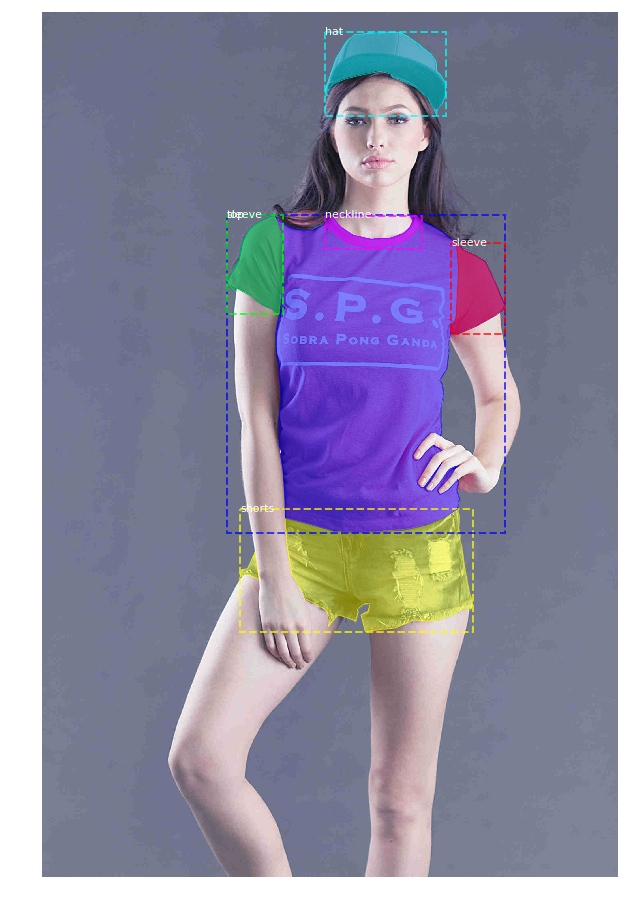

In [10]:
# Load random image and mask.
image_id = random.choice(dataset_train.image_ids)
image = dataset_train.load_image(image_id)
mask, class_ids = dataset_train.load_mask(image_id)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, dataset_train.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset_train.class_names)

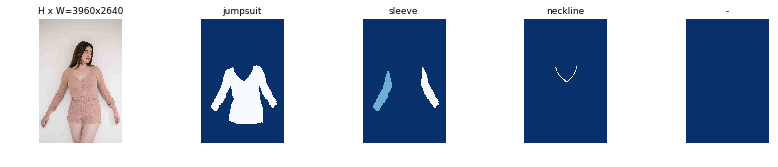

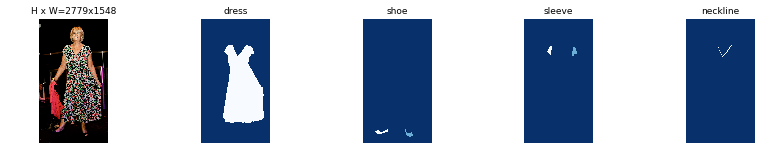

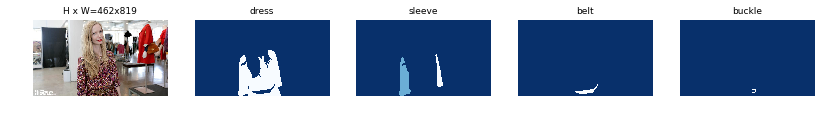

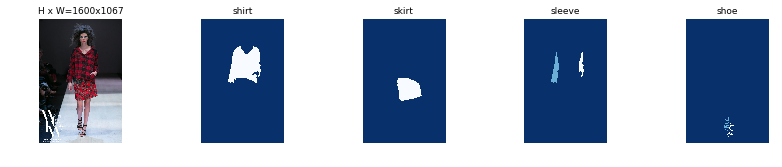

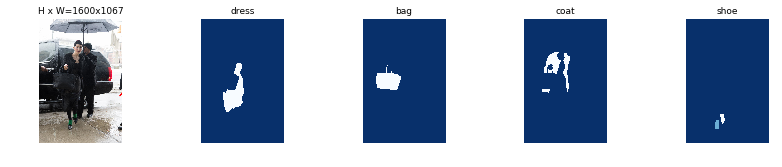

In [11]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 5)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

In [52]:
config = FashionConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.95
DETECTION_NMS_THRESHOLD        0.0
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                59
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [53]:
# Directory to save logs and trained model
MODEL_DIR = os.path.join(DATASET_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(DATASET_DIR, "mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

In [54]:
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

# Exclude the last layers because they require a matching
# number of classes
model.load_weights(COCO_MODEL_PATH, by_name=True,
                   exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                            "mrcnn_bbox", "mrcnn_mask"])

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all"` to train all layers.

In [15]:
# Train dataset
dataset_train = FashionDataset(DATASET_DIR)
dataset_train.load_fashion("train")
dataset_train.prepare()
    
# Validation dataset
dataset_val = FashionDataset(DATASET_DIR)
dataset_val.load_fashion("val")
dataset_val.prepare()

Total: 36596
Batch Size: 36596
Unique: 36596



Total: 9029
Batch Size: 9029
Unique: 9029


In [26]:
train(model, config, dataset_train, dataset_val)

Training network heads

Starting at epoch 0. LR=0.001

Checkpoint Path: ../../data/FashionDataSet/logs/imaterialist20191207T0103/mask_rcnn_imaterialist_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_c

/opt/anaconda/anaconda3/envs/MaskRCNN-gpu/lib/python3.6/site-packages/keras/engine/training.py:2142: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


1000/1000 [==============================] - 656s - loss: 2.4763 - rpn_class_loss: 0.1159 - rpn_bbox_loss: 0.8006 - mrcnn_class_loss: 0.5492 - mrcnn_bbox_loss: 0.5368 - mrcnn_mask_loss: 0.4738 - val_loss: 2.2299 - val_rpn_class_loss: 0.1137 - val_rpn_bbox_loss: 0.7505 - val_mrcnn_class_loss: 0.5639 - val_mrcnn_bbox_loss: 0.4380 - val_mrcnn_mask_loss: 0.3637
Epoch 2/20
1000/1000 [==============================] - 501s - loss: 2.1589 - rpn_class_loss: 0.1008 - rpn_bbox_loss: 0.7833 - mrcnn_class_loss: 0.4968 - mrcnn_bbox_loss: 0.4165 - mrcnn_mask_loss: 0.3616 - val_loss: 1.9970 - val_rpn_class_loss: 0.0967 - val_rpn_bbox_loss: 0.6488 - val_mrcnn_class_loss: 0.5410 - val_mrcnn_bbox_loss: 0.3923 - val_mrcnn_mask_loss: 0.3183
Epoch 3/20
1000/1000 [==============================] - 492s - loss: 2.0053 - rpn_class_loss: 0.0889 - rpn_bbox_loss: 0.7260 - mrcnn_class_loss: 0.4756 - mrcnn_bbox_loss: 0.3800 - mrcnn_mask_loss: 0.3348 - val_loss: 1.8769 - val_rpn_class_loss: 0.0712 - val_rpn_bbox_lo

## Inference

In [35]:
class InferenceConfig(FashionConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    
    # Skip detections with < 60% confidence
    DETECTION_MIN_CONFIDENCE = 0.6

In [36]:
config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.6
DETECTION_NMS_THRESHOLD        0.0
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                59
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE          

In [37]:
# Create model in inference mode
model = modellib.MaskRCNN(mode="inference", config=config,
                          model_dir=MODEL_DIR)
weights_path = model.find_last()

# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  ../../data/FashionDataSet/logs/imaterialist20191207T0103/mask_rcnn_imaterialist_0019.h5
Re-starting from epoch 19


image ID: imaterialist.8ed0e1a13c5f65ac96f5f174b0277f5d.jpg (23772) 8ed0e1a13c5f65ac96f5f174b0277f5d.jpg
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 59)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
gt_class_id              shape: (7,)                  min:    1.00000  max:   34.00000  int32
gt_bbox                  shape: (7, 4)                min:  209.00000  max: 1023.00000  int32
gt_mask                  shape: (1024, 1024, 7)       min:    0.00000  max:    1.00000  bool


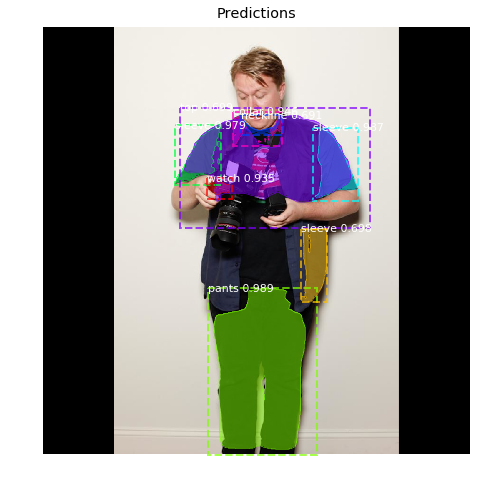

In [46]:
image_id = random.choice(dataset_train.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_train, config, image_id, use_mini_mask=False)
info = dataset_train.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset_train.image_reference(image_id)))
# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_train.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

## Precision-Recall

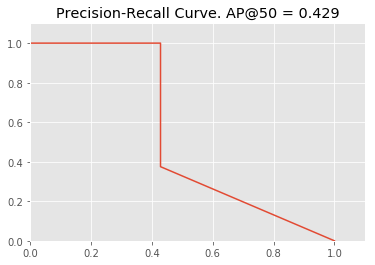

In [47]:
# Draw precision-recall curve
AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                          r['rois'], r['class_ids'], r['scores'], r['masks'])
visualize.plot_precision_recall(AP, precisions, recalls)

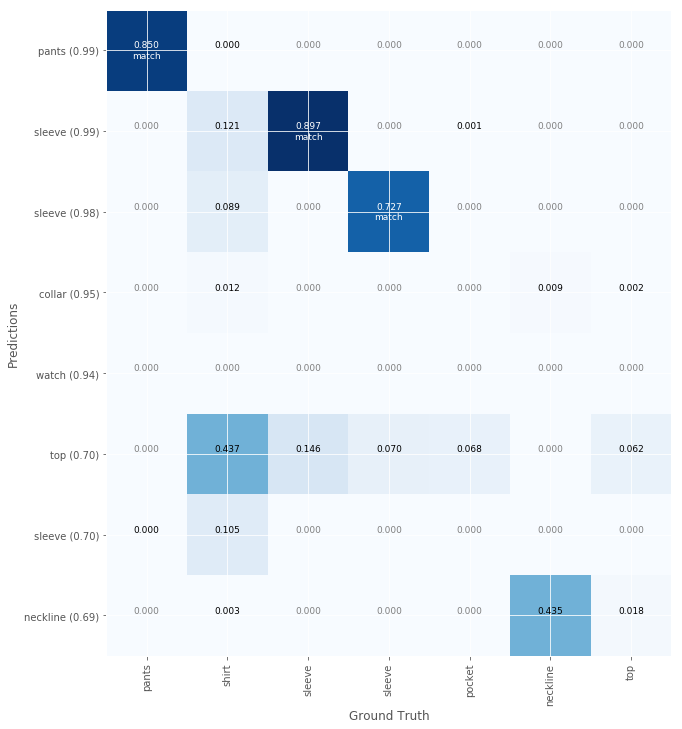

In [48]:
# Grid of ground truth objects and their predictions
visualize.plot_overlaps(gt_class_id, r['class_ids'], r['scores'],
                        overlaps, dataset_train.class_names)

## Compute mAP @ IoU=50 on Batch of Images¶

In [42]:
# Compute VOC-style Average Precision
def compute_batch_ap(image_ids):
    APs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset_train, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect([image], verbose=0)
        # Compute AP
        r = results[0]
        AP, precisions, recalls, overlaps =\
            utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                              r['rois'], r['class_ids'], r['scores'], r['masks'])
        APs.append(AP)
    return APs

# Pick a set of random images
image_ids = np.random.choice(dataset_train.image_ids, 50)
APs = compute_batch_ap(image_ids)
print("mAP @ IoU=50: ", np.mean(APs))

mAP @ IoU=50:  0.3935373124059231
